--- 1. Setting up Environment ---


/Users/chrysis/anaconda3/envs/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to /Users/chrysis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Setup complete.

--- 2. Data Handling and Pre-Processing ---
Loading TweetEval sentiment dataset...
Dataset loaded:
Train shape: (45615, 3)
Validation shape: (2000, 3)
Test shape: (12284, 3)
                                                text  label sentiment
0  "QT @user In the original draft of the 7th boo...      2  Positive
1  "Ben Smith / Smith (concussion) remains out of...      1   Neutral
2  Sorry bout the stream last night I crashed out...      1   Neutral
Setting up pre-processing function...
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Applying pre-processing to train, validation, and test sets...
Pre-processing completed in 20.98 seconds.
                                                text  \
0  "QT @user In the original draft of the 7th boo...   
1  "Ben Smith / Smith (concussion) remains out of...   
2  Sorry bout the stream last night I crashed out...   

                                      processed_text  
0  original draft book remus lupin survived bat

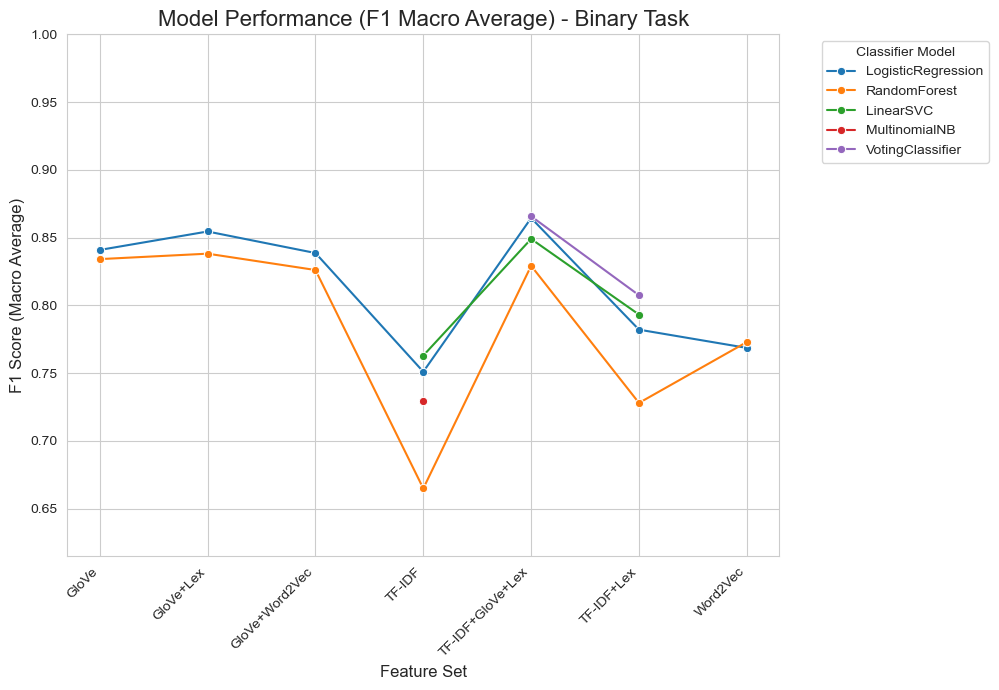

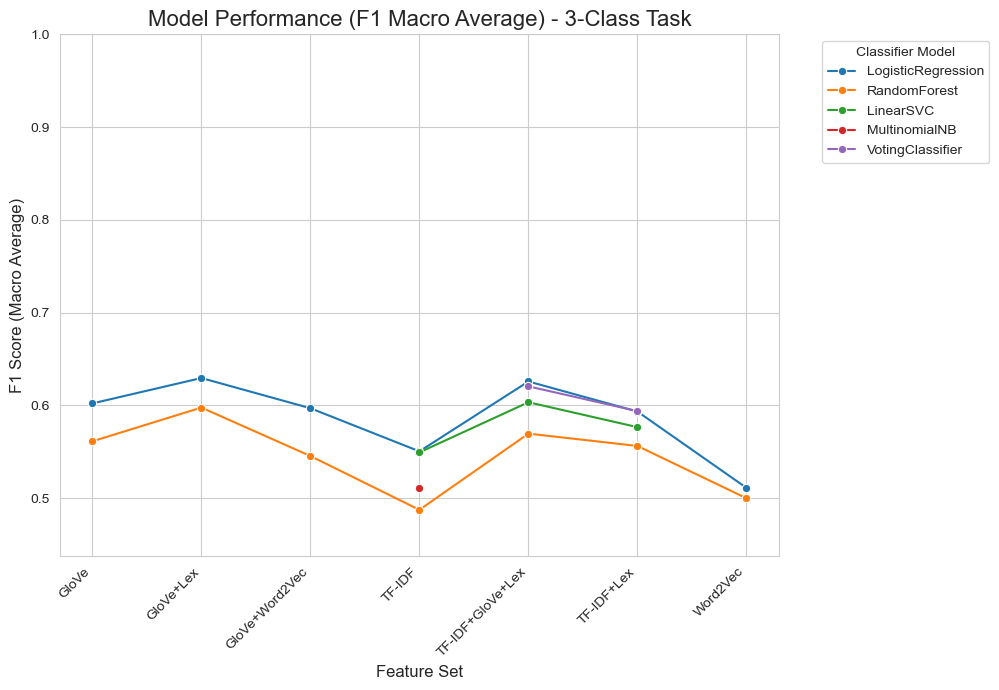


--- 6. End of Script ---


In [1]:
"""
Twitter Sentiment Classification with NLP
"""

# 0. Requirements
# ---------------
# This script requires the following libraries:
# pip install pandas numpy matplotlib seaborn
# pip install datasets preprocessor nltk scikit-learn gensim vaderSentiment ekphrasis
# pip install twokenize
#
# GloVe Embeddings Setup:
# 1. Download the Twitter GloVe embeddings from: https://nlp.stanford.edu/projects/glove/
#    (Specifically: glove.twitter.27B.zip)
# 2. Extract the zip file to create a folder named 'glove.twitter.27B' in the same directory as this script
# 3. Ensure the file 'glove.twitter.27B.100d.txt' is available in that folder
#    (The script is configured to use the 100-dimensional Twitter GloVe vectors)
#
# Note: If GloVe embeddings are not available, the script will still run but will skip
# any feature combinations that require GloVe.

# 1. Setup and Imports
print("--- 1. Setting up Environment ---")
import pandas as pd
import numpy as np
import re
import time
import warnings
import os # For file operations (GloVe)
import matplotlib.pyplot as plt 
import seaborn as sns 
import html        
import twokenize   

# Data Handling & Pre-processing
import datasets
import preprocessor as p 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer # For Lexicon Features
from ekphrasis.classes.segmenter import Segmenter # Added for hashtag segmentation

# Feature Engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec # Using Gensim's Word2Vec

# Model Training & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from scipy.sparse import hstack # To combine sparse features


# NLTK Downloads (if not already present)
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')

warnings.filterwarnings('ignore')

print("Setup complete.")

# 2. Data Handling and Pre-Processing
print("\n--- 2. Data Handling and Pre-Processing ---")

# 2.1 Data Loading 
print("Loading TweetEval sentiment dataset...")
dataset = datasets.load_dataset("tweet_eval", "sentiment")

# Convert to Pandas DataFrames
df_train = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

# Map labels to names for clarity 
int_to_label = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
label_to_int = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
# Define binary mapping specifically as well
int_to_label_bin = {0: 'Negative', 1: 'Positive'}
label_to_int_bin = {'Negative': 0, 'Positive': 1}

df_train['sentiment'] = df_train['label'].map(int_to_label)
df_val['sentiment'] = df_val['label'].map(int_to_label)
df_test['sentiment'] = df_test['label'].map(int_to_label)

print("Dataset loaded:")
print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")
print(df_train.head(3)) 

# 2.2 Text Cleaning and Normalization (Using tweet-preprocessor)
print("Setting up pre-processing function...")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Instantiate the hashtag segmenter
segmenter = Segmenter(corpus="twitter") 

# Configure tweet-preprocessor
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED, p.OPT.EMOJI, p.OPT.SMILEY)

# Function to handle contractions 
def uncontract(text):
    text = re.sub(r"(\b)([Aa]re|[Cc]ould|[Dd]id|[Dd]oes|[Dd]o|[Hh]ad|[Hh]as|[Hh]ave|[Ii]s|[Mm]ight|[Mm]ust|[Ss]hould|[Ww]ere|[Ww]ould)n't", r"\1\2 not", text)
    text = re.sub(r"(\b)([Hh]e|[Ii]|[Ss]he|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'ll", r"\1\2 will", text)
    text = re.sub(r"(\b)([Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'re", r"\1\2 are", text)
    text = re.sub(r"(\b)([Ii]|[Ss]hould|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Ww]ould|[Yy]ou)'ve", r"\1\2 have", text)
    text = re.sub(r"(\b)([Cc]a)n't", r"\1\2n not", text)
    text = re.sub(r"(\b)([Ii])'m", r"\1\2 am", text)
    text = re.sub(r"(\b)([Ll]et)'s", r"\1\2 us", text)
    text = re.sub(r"(\b)([Tt]here)'s", r"\1\2 is", text)
    text = re.sub(r"(\b)([Ww])on't", r"\1\2ill not", text)
    text = re.sub(r"(\b)([Ss])han't", r"\1\2hall not", text)
    text = re.sub(r"(\b)([Yy])(?:'all|a'll)", r"\1\2ou all", text)
    return text

def preprocess_tweet(text):
    """Cleans, normalizes, tokenizes, segments hashtags, and lemmatizes a tweet."""
    # Expand contractions first
    text = uncontract(text)
    # Clean using tweet-preprocessor (removes URLs, mentions, etc.)
    cleaned_text = p.clean(text)
    # Lowercase
    cleaned_text = cleaned_text.lower()
    # Unescape HTML entities before tokenizing
    unescaped_text = html.unescape(cleaned_text)
    # Tokenize using twokenize
    tokens = twokenize.tokenize(unescaped_text)
    processed_tokens = []
    for token in tokens:
        # Handle hashtag segmentation - identifies hashtags, removes the # symbol,
        # splits compound words (e.g., #MachineLearning → machine learning),
        # and adds the individual words to processed tokens
        if segmenter and token.startswith('#') and len(token) > 1:
            # Segment hashtag
            segmented_hashtag = segmenter.segment(token[1:])
            processed_tokens.extend(segmented_hashtag.split())
        else:
            # Keep regular tokens
            processed_tokens.append(token)

    # lemmatization, stop word removal, and final cleanup
    final_tokens = []
    for word in processed_tokens:
        # Remove remaining punctuation/numbers 
        word_cleaned = re.sub(r'[^a-z]', '', word)
        if word_cleaned and word_cleaned not in stop_words and len(word_cleaned) > 2: # remove empty words and stop words and words less than 2 characters
            lemmatized_word = lemmatizer.lemmatize(word_cleaned)
            final_tokens.append(lemmatized_word)
    return " ".join(final_tokens)

# Apply pre-processing to all splits
print("Applying pre-processing to train, validation, and test sets...")
start_time = time.time()
df_train['processed_text'] = df_train['text'].apply(preprocess_tweet)
df_val['processed_text'] = df_val['text'].apply(preprocess_tweet)
df_test['processed_text'] = df_test['text'].apply(preprocess_tweet)
end_time = time.time()
print(f"Pre-processing completed in {end_time - start_time:.2f} seconds.")

print(df_train[['text', 'processed_text']].head(3)) 

# Prepare data for binary classification (Positive vs. Negative)
df_train_bin = df_train[df_train['label'] != label_to_int['Neutral']].copy()
df_val_bin = df_val[df_val['label'] != label_to_int['Neutral']].copy()
df_test_bin = df_test[df_test['label'] != label_to_int['Neutral']].copy()

# Remap binary labels (0: Negative, 2: Positive -> 0: Negative, 1: Positive)
# The target column is named 'label' for consistency.
df_train_bin['label'] = df_train_bin['label'].map({0: 0, 2: 1})
df_val_bin['label'] = df_val_bin['label'].map({0: 0, 2: 1})
df_test_bin['label'] = df_test_bin['label'].map({0: 0, 2: 1})
# Keep the old name for compatibility with existing code if needed
df_train_bin['label_bin'] = df_train_bin['label']
df_val_bin['label_bin'] = df_val_bin['label']
df_test_bin['label_bin'] = df_test_bin['label']

print("\nData prepared for binary classification:")
print(f"Train Binary shape: {df_train_bin.shape}")
print(f"Validation Binary shape: {df_val_bin.shape}")
print(f"Test Binary shape: {df_test_bin.shape}")

# Define target variables
# Three-Class
y_train_3 = df_train['label']
y_val_3 = df_val['label']
y_test_3 = df_test['label']
# Binary (using the remapped 'label' column)
y_train_bin = df_train_bin['label']
y_val_bin = df_val_bin['label']
y_test_bin = df_test_bin['label']

# 3. Feature Engineering
print("\n--- 3. Feature Engineering ---")

# Using processed text for BoW, TF-IDF, Word2Vec
corpus_train_3 = df_train['processed_text']
corpus_val_3 = df_val['processed_text']
corpus_test_3 = df_test['processed_text']

corpus_train_bin = df_train_bin['processed_text']
corpus_val_bin = df_val_bin['processed_text']
corpus_test_bin = df_test_bin['processed_text']

# Using original text for VADER lexicon features because VADER uses rules-based approach on original text
orig_corpus_train_3 = df_train['text']
orig_corpus_val_3 = df_val['text']
orig_corpus_test_3 = df_test['text']
orig_corpus_train_bin = df_train_bin['text']
orig_corpus_val_bin = df_val_bin['text']
orig_corpus_test_bin = df_test_bin['text']


# 3.1 Bag of Words (BoW)
print("Generating BoW features...")
vectorizer_bow = CountVectorizer(max_features=5000, ngram_range=(1, 2)) # Added bigrams
X_train_bow_3 = vectorizer_bow.fit_transform(corpus_train_3)
X_val_bow_3 = vectorizer_bow.transform(corpus_val_3)
X_test_bow_3 = vectorizer_bow.transform(corpus_test_3)

X_train_bow_bin = vectorizer_bow.transform(corpus_train_bin) # Use same vocab fitted on all train data
X_val_bow_bin = vectorizer_bow.transform(corpus_val_bin)
X_test_bow_bin = vectorizer_bow.transform(corpus_test_bin)
print(f"BoW feature shape (Train 3-Class): {X_train_bow_3.shape}")
print(f"BoW feature shape (Train Binary): {X_train_bow_bin.shape}")

# 3.2 TF-IDF
print("Generating TF-IDF features...")
vectorizer_tfidf = TfidfVectorizer(
    max_features=5000,  # limit the number of features
    ngram_range=(1, 2), # Added bigrams 
    min_df=5,           # Ignore terms that appear in less than 5 documents
    max_df=0.9          # Ignore terms that appear in more than 90% of the documents
)
X_train_tfidf_3 = vectorizer_tfidf.fit_transform(corpus_train_3)
X_val_tfidf_3 = vectorizer_tfidf.transform(corpus_val_3)
X_test_tfidf_3 = vectorizer_tfidf.transform(corpus_test_3)

X_train_tfidf_bin = vectorizer_tfidf.transform(corpus_train_bin) # Use same vectorizer fitted on all train data
X_val_tfidf_bin = vectorizer_tfidf.transform(corpus_val_bin)
X_test_tfidf_bin = vectorizer_tfidf.transform(corpus_test_bin)
print(f"TF-IDF feature shape (Train 3-Class): {X_train_tfidf_3.shape}")
print(f"TF-IDF feature shape (Train Binary): {X_train_tfidf_bin.shape}")


# 3.3 Word Embeddings (Word2Vec - Averaging)
print("Generating Word2Vec features (Averaging)...")
tokenized_corpus_train_3 = [text.split() for text in corpus_train_3]
w2v_model = Word2Vec(
    sentences=tokenized_corpus_train_3,  # Input data as a list of tokenized sentences.
    vector_size=100,                      # Dimensionality of the word vectors (100 dimensions).
    window=5,                             # Maximum distance between the current and predicted word (5 words).
    min_count=2,                          # Minimum frequency of words to be included in the model (at least 2 occurrences).
    workers=4,                            # Number of worker threads to train the model (4 threads for parallel processing).
    sg=1                                   # Use Skip-gram model for training (1 for Skip-gram, 0 for CBOW).
)  

def vectorize_tweet_w2v(tweet_tokens, model, vector_size):
    """Averages Word2Vec vectors for tokens in a tweet."""
    vectors = [model.wv[word] for word in tweet_tokens if word in model.wv]
    if not vectors:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Function to apply vectorization
def apply_w2v_vectorization(corpus, model, vector_size):
    tokenized_corpus = [text.split() for text in corpus]
    return np.array([vectorize_tweet_w2v(tokens, model, vector_size) for tokens in tokenized_corpus])

X_train_w2v_3 = apply_w2v_vectorization(corpus_train_3, w2v_model, 100)
X_val_w2v_3 = apply_w2v_vectorization(corpus_val_3, w2v_model, 100)
X_test_w2v_3 = apply_w2v_vectorization(corpus_test_3, w2v_model, 100)

X_train_w2v_bin = apply_w2v_vectorization(corpus_train_bin, w2v_model, 100)
X_val_w2v_bin = apply_w2v_vectorization(corpus_val_bin, w2v_model, 100)
X_test_w2v_bin = apply_w2v_vectorization(corpus_test_bin, w2v_model, 100)

# Scale Word2Vec features
scaler_w2v = StandardScaler()
X_train_w2v_3 = scaler_w2v.fit_transform(X_train_w2v_3)
X_val_w2v_3 = scaler_w2v.transform(X_val_w2v_3)
X_test_w2v_3 = scaler_w2v.transform(X_test_w2v_3)

X_train_w2v_bin = scaler_w2v.transform(X_train_w2v_bin) # Use same scaler
X_val_w2v_bin = scaler_w2v.transform(X_val_w2v_bin)
X_test_w2v_bin = scaler_w2v.transform(X_test_w2v_bin)

print(f"Word2Vec feature shape (Train 3-Class): {X_train_w2v_3.shape}")
print(f"Word2Vec feature shape (Train Binary): {X_train_w2v_bin.shape}")

# --- ADD GloVe Configuration ---
# Define the path to your downloaded GloVe file
# !! IMPORTANT: Update this path to where you saved the GloVe file !!
# Example: Using GloVe Twitter 100d vectors
GLOVE_EMBEDDING_FILE = './glove.twitter.27B/glove.twitter.27B.100d.txt' 
EMBEDDING_DIM_GLOVE = 100 # Make sure this matches the '100d' in the filename
# -----------------------------

# 3.3.1 Word Embeddings (GloVe - Averaging)
print("Generating GloVe features (Averaging)...")
embedding_index_glove = {} 
if os.path.exists(GLOVE_EMBEDDING_FILE):
    try:
        with open(GLOVE_EMBEDDING_FILE, 'r', encoding='utf-8') as f:
            for line in f:
                # Split each line into a word and its corresponding vector, 
                # then store them if the vector has the correct dimension.
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                if len(vector) == EMBEDDING_DIM_GLOVE: # Ensure correct dimension
                     embedding_index_glove[word] = vector
        print(f"Loaded {len(embedding_index_glove)} word vectors from GloVe.")
    except Exception as e:
        print(f"Error loading GloVe file '{GLOVE_EMBEDDING_FILE}': {e}")
        embedding_index_glove = {} # Ensure it's empty if loading fails
else:
    print(f"GloVe file '{GLOVE_EMBEDDING_FILE}' not found. Skipping GloVe feature generation.")

def vectorize_tweet_glove(tweet_tokens, embedding_index, vector_size):
    """Averages GloVe vectors for tokens in a tweet."""
    vectors = [embedding_index[word] for word in tweet_tokens if word in embedding_index]
    if not vectors:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Function to apply GloVe vectorization
def apply_glove_vectorization(corpus, embedding_index, vector_size):
    if not embedding_index: # If GloVe failed to load
        print("GloVe embeddings not available, returning zero vectors.")
        return np.zeros((len(corpus), vector_size))
    tokenized_corpus = [text.split() for text in corpus]
    return np.array([vectorize_tweet_glove(tokens, embedding_index, vector_size) for tokens in tokenized_corpus])

if embedding_index_glove: # Only proceed if GloVe loaded successfully
    X_train_glove_3 = apply_glove_vectorization(corpus_train_3, embedding_index_glove, EMBEDDING_DIM_GLOVE)
    X_val_glove_3 = apply_glove_vectorization(corpus_val_3, embedding_index_glove, EMBEDDING_DIM_GLOVE)
    X_test_glove_3 = apply_glove_vectorization(corpus_test_3, embedding_index_glove, EMBEDDING_DIM_GLOVE)

    X_train_glove_bin = apply_glove_vectorization(corpus_train_bin, embedding_index_glove, EMBEDDING_DIM_GLOVE)
    X_val_glove_bin = apply_glove_vectorization(corpus_val_bin, embedding_index_glove, EMBEDDING_DIM_GLOVE)
    X_test_glove_bin = apply_glove_vectorization(corpus_test_bin, embedding_index_glove, EMBEDDING_DIM_GLOVE)

    # Scale GloVe features
    scaler_glove = StandardScaler()
    X_train_glove_3 = scaler_glove.fit_transform(X_train_glove_3)
    X_val_glove_3 = scaler_glove.transform(X_val_glove_3)
    X_test_glove_3 = scaler_glove.transform(X_test_glove_3)

    X_train_glove_bin = scaler_glove.transform(X_train_glove_bin) # Use same scaler
    X_val_glove_bin = scaler_glove.transform(X_val_glove_bin)
    X_test_glove_bin = scaler_glove.transform(X_test_glove_bin)

    print(f"GloVe feature shape (Train 3-Class): {X_train_glove_3.shape}")
    print(f"GloVe feature shape (Train Binary): {X_train_glove_bin.shape}")

# 3.4 Sentiment Lexicons (VADER)
print("Generating Sentiment Lexicon features (VADER)...")
analyzer = SentimentIntensityAnalyzer()

def get_vader_features(corpus):
    """Extracts VADER sentiment scores for a corpus."""
    feature_list = []
    for text in corpus:
        vs = analyzer.polarity_scores(text)
        feature_list.append([vs['neg'], vs['neu'], vs['pos'], vs['compound']])
    return np.array(feature_list)

# Use original text for VADER
X_train_lex_3 = get_vader_features(orig_corpus_train_3)
X_val_lex_3 = get_vader_features(orig_corpus_val_3)
X_test_lex_3 = get_vader_features(orig_corpus_test_3)

X_train_lex_bin = get_vader_features(orig_corpus_train_bin)
X_val_lex_bin = get_vader_features(orig_corpus_val_bin)
X_test_lex_bin = get_vader_features(orig_corpus_test_bin)

# Scale Lexicon features
scaler_lex = StandardScaler()
X_train_lex_3 = scaler_lex.fit_transform(X_train_lex_3)
X_val_lex_3 = scaler_lex.transform(X_val_lex_3)
X_test_lex_3 = scaler_lex.transform(X_test_lex_3)

X_train_lex_bin = scaler_lex.transform(X_train_lex_bin) # Use same scaler
X_val_lex_bin = scaler_lex.transform(X_val_lex_bin)
X_test_lex_bin = scaler_lex.transform(X_test_lex_bin)

print(f"Lexicon feature shape (Train 3-Class): {X_train_lex_3.shape}")
print(f"Lexicon feature shape (Train Binary): {X_train_lex_bin.shape}")

# 3.5 Combined Features 
# Use hstack for sparse (TF-IDF) + dense (Lexicon)
# hstack combines feature matrices horizontally; 
# tocsr converts the result to CSR format for efficient processing.

# 3.5.1 Combined Features: TF-IDF + Lexicon
X_train_tfidf_lex_3 = hstack([X_train_tfidf_3, X_train_lex_3]).tocsr()  
X_val_tfidf_lex_3 = hstack([X_val_tfidf_3, X_val_lex_3]).tocsr()
X_test_tfidf_lex_3 = hstack([X_test_tfidf_3, X_test_lex_3]).tocsr()

X_train_tfidf_lex_bin = hstack([X_train_tfidf_bin, X_train_lex_bin]).tocsr()
X_val_tfidf_lex_bin = hstack([X_val_tfidf_bin, X_val_lex_bin]).tocsr()
X_test_tfidf_lex_bin = hstack([X_test_tfidf_bin, X_test_lex_bin]).tocsr()

print(f"Combined TF-IDF+Lexicon shape (Train 3-Class): {X_train_tfidf_lex_3.shape}")
print(f"Combined TF-IDF+Lexicon shape (Train Binary): {X_train_tfidf_lex_bin.shape}")

# 3.5.2 Combined Features: GloVe + Lexicon
if embedding_index_glove: # Check if GloVe features were loaded
    X_train_glove_lex_3 = np.hstack([X_train_glove_3, X_train_lex_3])
    X_val_glove_lex_3 = np.hstack([X_val_glove_3, X_val_lex_3])
    X_test_glove_lex_3 = np.hstack([X_test_glove_3, X_test_lex_3])
    X_train_glove_lex_bin = np.hstack([X_train_glove_bin, X_train_lex_bin])
    X_val_glove_lex_bin = np.hstack([X_val_glove_bin, X_val_lex_bin])
    X_test_glove_lex_bin = np.hstack([X_test_glove_bin, X_test_lex_bin])
    print(f"Combined GloVe+Lexicon shape (Train 3-Class): {X_train_glove_lex_3.shape}")
    print(f"Combined GloVe+Lexicon shape (Train Binary): {X_train_glove_lex_bin.shape}")

# 3.5.3 Combined Features: TF-IDF + GloVe + Lexicon
if embedding_index_glove: # Check if GloVe features were loaded
    X_train_tfidf_glove_lex_3 = hstack([X_train_tfidf_3, X_train_glove_3, X_train_lex_3]).tocsr()
    X_val_tfidf_glove_lex_3 = hstack([X_val_tfidf_3, X_val_glove_3, X_val_lex_3]).tocsr()
    X_test_tfidf_glove_lex_3 = hstack([X_test_tfidf_3, X_test_glove_3, X_test_lex_3]).tocsr()
    X_train_tfidf_glove_lex_bin = hstack([X_train_tfidf_bin, X_train_glove_bin, X_train_lex_bin]).tocsr()
    X_val_tfidf_glove_lex_bin = hstack([X_val_tfidf_bin, X_val_glove_bin, X_val_lex_bin]).tocsr()
    X_test_tfidf_glove_lex_bin = hstack([X_test_tfidf_bin, X_test_glove_bin, X_test_lex_bin]).tocsr()
    print(f"Combined TF-IDF+GloVe+Lexicon shape (Train 3-Class): {X_train_tfidf_glove_lex_3.shape}")
    print(f"Combined TF-IDF+GloVe+Lexicon shape (Train Binary): {X_train_tfidf_glove_lex_bin.shape}")

# 3.5.4 Combined Features: GloVe + Word2Vec
if embedding_index_glove: # Check if GloVe features were loaded
    # Combine the scaled GloVe and scaled Word2Vec features
    X_train_glove_w2v_3 = np.hstack([X_train_glove_3, X_train_w2v_3])
    X_val_glove_w2v_3 = np.hstack([X_val_glove_3, X_val_w2v_3])
    X_test_glove_w2v_3 = np.hstack([X_test_glove_3, X_test_w2v_3])
    X_train_glove_w2v_bin = np.hstack([X_train_glove_bin, X_train_w2v_bin])
    X_val_glove_w2v_bin = np.hstack([X_val_glove_bin, X_val_w2v_bin])
    X_test_glove_w2v_bin = np.hstack([X_test_glove_bin, X_test_w2v_bin])
    print(f"Combined GloVe+Word2Vec shape (Train 3-Class): {X_train_glove_w2v_3.shape}")
    print(f"Combined GloVe+Word2Vec shape (Train Binary): {X_train_glove_w2v_bin.shape}")

# Store features and targets in dictionaries for easier access
features = {
    'BoW': (X_train_bow_3, X_val_bow_3, X_test_bow_3, X_train_bow_bin, X_val_bow_bin, X_test_bow_bin),
    'TF-IDF': (X_train_tfidf_3, X_val_tfidf_3, X_test_tfidf_3, X_train_tfidf_bin, X_val_tfidf_bin, X_test_tfidf_bin),
    'Word2Vec': (X_train_w2v_3, X_val_w2v_3, X_test_w2v_3, X_train_w2v_bin, X_val_w2v_bin, X_test_w2v_bin),
    'GloVe': (X_train_glove_3, X_val_glove_3, X_test_glove_3, X_train_glove_bin, X_val_glove_bin, X_test_glove_bin) if embedding_index_glove else None,
    'Lexicon': (X_train_lex_3, X_val_lex_3, X_test_lex_3, X_train_lex_bin, X_val_lex_bin, X_test_lex_bin),
    'TF-IDF+Lex': (X_train_tfidf_lex_3, X_val_tfidf_lex_3, X_test_tfidf_lex_3, X_train_tfidf_lex_bin, X_val_tfidf_lex_bin, X_test_tfidf_lex_bin),
    'GloVe+Lex': (X_train_glove_lex_3, X_val_glove_lex_3, X_test_glove_lex_3, X_train_glove_lex_bin, X_val_glove_lex_bin, X_test_glove_lex_bin) if embedding_index_glove else None,
    'TF-IDF+GloVe+Lex': (X_train_tfidf_glove_lex_3, X_val_tfidf_glove_lex_3, X_test_tfidf_glove_lex_3, X_train_tfidf_glove_lex_bin, X_val_tfidf_glove_lex_bin, X_test_tfidf_glove_lex_bin) if embedding_index_glove else None,
    'GloVe+Word2Vec': (X_train_glove_w2v_3, X_val_glove_w2v_3, X_test_glove_w2v_3, X_train_glove_w2v_bin, X_val_glove_w2v_bin, X_test_glove_w2v_bin) if embedding_index_glove else None
}

# Remove None entries if GloVe failed to load
features = {k: v for k, v in features.items() if v is not None}

targets = {
    '3-Class': (y_train_3, y_val_3, y_test_3),
    'Binary': (y_train_bin, y_val_bin, y_test_bin)
}

# 4. Model Evaluation on Test Set 
print("\n--- 4. Model Evaluation on Test Set ---")

final_results = {}
models_to_evaluate = { 
    # Define models and their types (sparse/dense preference)
    # This helps in selecting appropriate features for evaluation.
    'LogisticRegression': 'any',
    'LinearSVC': 'sparse', # Use LinearSVC for sparse data
    'RandomForest': 'any',
    'MultinomialNB': 'sparse', 
    'VotingClassifier': 'sparse' # combine sparse models
}
# Define features to evaluate (ensure GloVe is included only if loaded)
features_to_evaluate = ['TF-IDF', 'Word2Vec', 'TF-IDF+Lex']
if 'GloVe' in features:
    features_to_evaluate.append('GloVe')
    if 'GloVe+Lex' in features:
        features_to_evaluate.append('GloVe+Lex')
    if 'TF-IDF+GloVe+Lex' in features:
        features_to_evaluate.append('TF-IDF+GloVe+Lex')
    if 'GloVe+Word2Vec' in features:
        features_to_evaluate.append('GloVe+Word2Vec')

# --- 4.1 Evaluation  --- 
for task in targets.keys(): # Iterate through 'Binary', '3-Class'
    final_results[task] = {}
    print(f"\n--- Evaluating Models for Task: {task} ---")
    # Set variables to select appropriate features and labels 
    # for binary or three-class evaluation.
    is_binary = (task == 'Binary')
    feature_idx_offset = 3 if is_binary else 0 # first 0-2 are for 3-class, 3-5 are for binary
    target_idx = 1 if is_binary else 0
    y_test = targets[task][2] # Index 2 is the test set target
    y_train_full = targets[task][0] # Get training labels

    for feature in features_to_evaluate: # Iterate through specified features
        # Skip feature if data is missing (e.g., GloVe failed to load)
        if features.get(feature) is None:
            print(f"--- Skipping Feature: {feature} (data not available) ---")
            continue
        final_results[task][feature] = {}
        print(f"--- Feature: {feature} ---")
        X_test = features[feature][2 + feature_idx_offset] # Index 2 is the test set features
        X_train_full = features[feature][0 + feature_idx_offset] # Get training data to fit final model
        # Check if feature is sparse 
        is_sparse = feature in ['TF-IDF', 'TF-IDF+Lex', 'BoW', 'TF-IDF+GloVe+Lex']
        feature_shape = X_train_full.shape if X_train_full is not None else (0,0)

        # Calculate Feature Size in Bytes
        feature_size_bytes = 0
        if X_train_full is not None:
            if is_sparse:
                feature_size_bytes = X_train_full.data.nbytes + X_train_full.indices.nbytes + X_train_full.indptr.nbytes
            else: # Dense numpy array
                feature_size_bytes = X_train_full.nbytes

        for model_name, model_type_pref in models_to_evaluate.items():
            # model_type_pref indicates the preferred data type (sparse or dense) for the model.
            # This helps in selecting appropriate features for evaluation.

            # Skip inappropriate model/feature combinations
            if model_name == 'LinearSVC' and not is_sparse:
                 print(f"Skipping LinearSVC for dense feature '{feature}'.")
                 continue

            # MNB requires non-negative features. TF-IDF/BoW are fine. Combined features might have negative values after scaling dense parts.
            if model_name == 'MultinomialNB' and feature not in ['TF-IDF', 'BoW']:
                 print(f"Skipping MultinomialNB for feature '{feature}' (requires non-negative count/TF-IDF features).")
                 continue

            #  VotingClassifier evaluating only on TF-IDF+Lex and TF-IDF+GloVe+Lex
            if model_name == 'VotingClassifier' and feature not in ['TF-IDF+Lex', 'TF-IDF+GloVe+Lex']:
                 print(f"Skipping VotingClassifier for feature '{feature}' (evaluating only on TF-IDF+Lex and TF-IDF+GloVe+Lex).")
                 continue

            # Handle cases where feature data might be None (e.g., GloVe failed)
            if X_train_full is None or X_test is None:
                print(f"Skipping {model_name} for feature '{feature}' due to missing data.")
                # Add placeholder entry to avoid key errors later
                final_results[task][feature][model_name] = {
                     'report': {'accuracy': 0.0, 'macro avg': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 0}},
                     'report_str': "Evaluation skipped: Missing feature data.",
                     'train_time': 0.0,
                     'prediction_time': 0.0,
                     'feature_shape': feature_shape,
                     'feature_size_bytes': feature_size_bytes
                }
                continue

            print(f"Evaluating {model_name}...")

            # Instantiate model with default parameters
            try:
                if model_name == 'LogisticRegression':
                     final_model = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
                elif model_name == 'LinearSVC':
                     final_model = LinearSVC(random_state=42, max_iter=2000, dual='auto')
                elif model_name == 'RandomForest':
                     final_model = RandomForestClassifier(random_state=42, n_jobs=-1)
                elif model_name == 'MultinomialNB':
                     final_model = MultinomialNB()
                elif model_name == 'VotingClassifier':
                     # Instantiate base estimators
                     clf1 = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
                     clf2 = LinearSVC(random_state=42, max_iter=2000, dual='auto')
                     final_model = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2)], voting='hard', n_jobs=-1) 
                else:
                     print(f"Warning: Model {model_name} not implemented for default evaluation.")
                     continue

                start_time_train = time.time()
                # Train on the full training set with default params
                final_model.fit(X_train_full, y_train_full)
                end_time_train = time.time()
                train_time = end_time_train - start_time_train

                start_time_pred = time.time()
                y_pred_test = final_model.predict(X_test)
                end_time_pred = time.time()
                prediction_time = end_time_pred - start_time_pred

                target_names_list = list(label_to_int.keys()) if not is_binary else list(label_to_int_bin.keys())
                # report dictionary
                report = classification_report(y_test, y_pred_test, target_names=target_names_list, output_dict=True, zero_division=0)  
                report_str = classification_report(y_test, y_pred_test, target_names=target_names_list, zero_division=0)

                final_results[task][feature][model_name] = {
                    'report': report,
                    'report_str': report_str,
                    'train_time': train_time,
                    'prediction_time': prediction_time, 
                    'feature_shape': feature_shape, 
                    'feature_size_bytes': feature_size_bytes 
                }

                print(f"Results for {model_name} ({feature}, {task}):")
                print(report_str)
                print(f"Training time: {train_time:.2f}s")
                print(f"Prediction time: {prediction_time:.2f}s")
                print(f"Feature Size (Train): {feature_size_bytes} bytes")
                print("-" * 30)

            except Exception as e:
                 print(f"ERROR evaluating {model_name} on {feature} for {task}: {e}")
                 final_results[task][feature][model_name] = {
                     'report': {'accuracy': 0.0, 'macro avg': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 0}},
                     'report_str': f"Evaluation failed: {e}",
                     'train_time': 0.0,
                     'prediction_time': 0.0, 
                     'feature_shape': feature_shape, 
                     'feature_size_bytes': feature_size_bytes 
                 }
                 print("-" * 30)


# 5. Summarizing Results and Findings 
print("\n--- 5. Summarizing Results and Findings ---")

# Create a summary DataFrame (Focusing on F1-score macro average)
summary_data = []
for task, task_results in final_results.items():
    for feature, feature_results in task_results.items():
        for model, model_results in feature_results.items():
            accuracy = model_results.get('report', {}).get('accuracy', 0.0) 
            macro_avg = model_results.get('report', {}).get('macro avg', {})
            f1_macro = macro_avg.get('f1-score', 0.0)
            precision_macro = macro_avg.get('precision', 0.0) 
            recall_macro = macro_avg.get('recall', 0.0) 

            feature_shape_str = str(model_results.get('feature_shape', 'N/A')) 
            feature_size = model_results.get('feature_size_bytes', 0) 
            prediction_time_val = model_results.get('prediction_time', 0.0) 

            summary_data.append({
                'Task': task,
                'FeatureSet': feature,
                'Model': model,
                'Feature_Shape': feature_shape_str, 
                'Feature_Size (Bytes)': feature_size, 
                # 'Accuracy': accuracy,
                'F1_Macro': f1_macro,
                # 'Precision_Macro': precision_macro,
                # 'Recall_Macro': recall_macro,
                'Train_Time (s)': model_results.get('train_time', 0.0), 
                'Prediction_Time (s)': prediction_time_val 
            })

summary_df = pd.DataFrame(summary_data)
# Ensure Train_Time is numeric before sorting
summary_df['Train_Time (s)'] = pd.to_numeric(summary_df['Train_Time (s)'], errors='coerce').fillna(0.0)
summary_df['Prediction_Time (s)'] = pd.to_numeric(summary_df['Prediction_Time (s)'], errors='coerce').fillna(0.0) 
summary_df['Feature_Size (Bytes)'] = pd.to_numeric(summary_df['Feature_Size (Bytes)'], errors='coerce').fillna(0)

# Sort by Task, F1_Macro desc, Train_Time asc
summary_df = summary_df.sort_values(by=['Task', 'F1_Macro', 'Train_Time (s)'], ascending=[True, False, True])

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) # Optional: Adjust width to prevent wrapping

print("\n## Performance Summary Table (Default Hyperparameters)")
print(summary_df)

# --- Written Summary ---
print("""
## Summary Discussion

Based on the evaluation using default hyperparameters:

### Key Insights:

*   **Feature Performance (3-Class):**
    *   The combination of **GloVe embeddings and VADER Lexicon features (`GloVe+Lex`)** achieved the highest Macro F1-score (around 0.63) with Logistic Regression, demonstrating the benefit of combining dense embeddings with sentiment scores.
    *   The most complex combination (**`TF-IDF+GloVe+Lex`**) also performed well (F1 ~0.62-0.63) with Logistic Regression and the Voting Classifier, but at a significantly higher computational cost (longer training times, largest feature size).
    *   Basic **TF-IDF** provided a reasonable baseline (F1 ~0.55), while **Word2Vec** (average pooling) performed slightly lower (F1 ~0.52) in this setup. VADER Lexicon features clearly boosted performance when added to TF-IDF or GloVe.
    *   The strong performance of combinations using GloVe with TF-IDF or Lexicon features suggests that combining features capturing *different* aspects of the text (semantics, term frequency, explicit sentiment) is more effective than combining highly similar embeddings like GloVe and Word2Vec might be.

*   **Feature Performance (Binary):**
    *   The **`TF-IDF+GloVe+Lex`** combination yielded the best Macro F1-score (around 0.86-0.87) with both Logistic Regression and the Voting Classifier.
    *   **`GloVe+Lex`** was a close second (F1 ~0.85-0.86), again primarily with Logistic Regression.
    *   Simple **GloVe** embeddings also performed strongly (F1 ~0.84).
    *   **TF-IDF combined with Lexicon features (`TF-IDF+Lex`)** showed a significant improvement over TF-IDF alone (F1 ~0.78-0.81 vs. ~0.75-0.76).
    *   Similar to the 3-class task, the success of combining diverse feature types (semantic, TF-IDF, lexicon) implies this is a more promising direction than combining GloVe and Word2Vec.

*   **Model Performance (Defaults):**
    *   **Logistic Regression** consistently performed well across most feature sets for both tasks, often achieving the best F1-scores or being very competitive, while generally having moderate training times.
    *   The **Voting Classifier** (combining Logistic Regression and LinearSVC for sparse features) showed strong performance on the combined sparse+dense features (`TF-IDF+Lex`, `TF-IDF+GloVe+Lex`), particularly for the Binary task, matching or slightly exceeding Logistic Regression's F1, albeit with longer training times.
    *   **LinearSVC** was efficient and effective for sparse features (`TF-IDF`, `TF-IDF+Lex`, `TF-IDF+GloVe+Lex`), often outperforming Logistic Regression in speed but sometimes slightly lagging in F1-score.
    *   **RandomForest** was generally slower and often achieved lower F1-scores compared to linear models, especially on the higher-dimensional combined features.
    *   **MultinomialNB** was extremely fast but only suitable for TF-IDF and performed less well than the other models on that feature set.

*   **Efficiency and Resource Usage:**
    *   There's a clear trade-off between feature complexity and performance/resource usage. Combining features (e.g., `TF-IDF+GloVe+Lex`) increased dimensionality (`Feature_Shape`), memory footprint (`Feature_Size (Bytes)`), and `Train_Time (s)` substantially compared to simpler features like TF-IDF or GloVe alone.
    *   Prediction times were generally very low for all models (< 0.1s), with RandomForest being slightly slower. Linear models (LogReg, LinearSVC, MNB) were fastest.

*   **Binary vs. Three-Class:** As expected, the Binary classification task achieved significantly higher performance metrics (Macro F1 ~0.87 achievable) compared to the Three-Class task (Macro F1 ~0.63 achievable). Distinguishing the neutral class remains a challenge.

*   **Impact of No Tuning:** These results represent baseline performance. Hyperparameter tuning would likely improve the scores for most model/feature combinations, potentially changing the relative rankings.

### Challenges Encountered:
*   **Pre-processing Impact:** The specific steps (lemmatization, stop word removal, hashtag segmentation) influence the resulting vocabulary and embeddings.
*   **Feature Combination:** Combining sparse (TF-IDF) and dense (GloVe, Lexicon) features requires careful handling (e.g., using `hstack`). Scaling dense features is important.
*   **Computational Cost:** Training models like Logistic Regression or LinearSVC on the combined high-dimensional features (`TF-IDF+GloVe+Lex`) took noticeably longer (~20-50 seconds for 3-Class, ~1-5 seconds for Binary) compared to simpler features (~0.1-3 seconds), even without tuning. RandomForest training time also increased with feature complexity.

### Potential Areas for Improvement:
*   **Hyperparameter Tuning:** Applying systematic tuning (e.g., GridSearchCV, RandomizedSearchCV, Optuna) is the most direct way to improve performance.
*   **Advanced Embeddings:** Experimenting with different pre-trained embeddings (FastText) or fine-tuning Word2Vec/GloVe on the specific dataset.
*   **Feature Engineering:** Exploring character n-grams, POS tags, or more sophisticated text statistics.
*   **Deep Learning Models:** Implementing CNNs or LSTMs/GRUs on top of GloVe/Word2Vec embeddings.
*   **Ensemble Methods:** Using stacking or more advanced voting strategies.
*   **Error Analysis:** Investigating misclassified examples for common patterns.
*   **Baseline Comparison:** Training a transformer-based model (like BERT or DistilBERT) on the text directly could provide a state-of-the-art comparison point (as allowed by instructions for comparison purposes).
""")

# --- 5.1 Plotting Results --- 
print("\n--- 5.1 Plotting Results ---")
# Ensure summary_df is sorted by FeatureSet for consistent line plot x-axis
summary_df_sorted = summary_df.sort_values(by=['Task', 'FeatureSet', 'Model'])

# Set plot style
sns.set_style("whitegrid")

# --- Plot for Binary Task ---
plt.figure(figsize=(12, 7)) 
df_binary = summary_df_sorted[summary_df_sorted['Task'] == 'Binary']

ax_bin = sns.lineplot(
    data=df_binary,
    x='FeatureSet',
    y='F1_Macro',
    hue='Model',
    marker='o', # Add markers to data points
    palette='tab10' # Use a standard color palette
)

plt.title('Model Performance (F1 Macro Average) - Binary Task', fontsize=16)
plt.xlabel('Feature Set', fontsize=12)
plt.ylabel('F1 Score (Macro Average)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels
plt.ylim(bottom=df_binary['F1_Macro'].min() - 0.05, top=1.0) # Adjust y-axis limits
plt.legend(title='Classifier Model', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.show()

# --- Plot for 3-Class Task ---
plt.figure(figsize=(12, 7)) 
df_3class = summary_df_sorted[summary_df_sorted['Task'] == '3-Class']

ax_3c = sns.lineplot(
    data=df_3class,
    x='FeatureSet',
    y='F1_Macro',
    hue='Model',
    marker='o',
    palette='tab10'
)

plt.title('Model Performance (F1 Macro Average) - 3-Class Task', fontsize=16)
plt.xlabel('Feature Set', fontsize=12)
plt.ylabel('F1 Score (Macro Average)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(bottom=df_3class['F1_Macro'].min() - 0.05, top=1.0) # Adjust y-axis limits based on 3-class data
plt.legend(title='Classifier Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


print("\n--- 6. End of Script ---") 